In [35]:
import sys

sys.path.insert(0, '../')
import utils.common as cm

import joblib
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer

In [3]:
train = cm.get_dataframe()
train.head()

,year,brand,model,vehicle_class,engine_size,cylinders,transmission,fuel_type,fuel_city_Lkm,fuel_hwy_Lkm,fuel_comb_Lkm,fuel_comb_mpg,co2
0,2002,FORD,FOCUS SEDAN #,COMPACT,2.0,4,A4,X,9.1,6.8,8.1,35,186
1,2021,Porsche,Panamera Turbo S,Full-size,4.0,8,AM8,Z,15.3,11.2,13.5,21,326
2,2011,INFINITI,EX35 AWD,STATION WAGON - SMALL,3.5,6,AS7,Z,12.4,8.5,10.6,27,244
3,2005,BUICK,RENDEZVOUS AWD,SUV,3.4,6,A4,X,12.7,8.7,10.9,26,251
4,2016,ROLLS-ROYCE,GHOST EWB,FULL-SIZE,6.6,12,AS8,Z,19.2,12.4,16.1,18,373


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18044 entries, 0 to 18043
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   year           18044 non-null  int64  
 1   brand          18044 non-null  object 
 2   model          18044 non-null  object 
 3   vehicle_class  18044 non-null  object 
 4   engine_size    18044 non-null  float64
 5   cylinders      18044 non-null  int64  
 6   transmission   18044 non-null  object 
 7   fuel_type      18044 non-null  object 
 8   fuel_city_Lkm  18044 non-null  float64
 9   fuel_hwy_Lkm   18044 non-null  float64
 10  fuel_comb_Lkm  18044 non-null  float64
 11  fuel_comb_mpg  18044 non-null  int64  
 12  co2            18044 non-null  int64  
dtypes: float64(4), int64(4), object(5)
memory usage: 1.8+ MB


In [5]:
target = "fuel_comb_mpg"

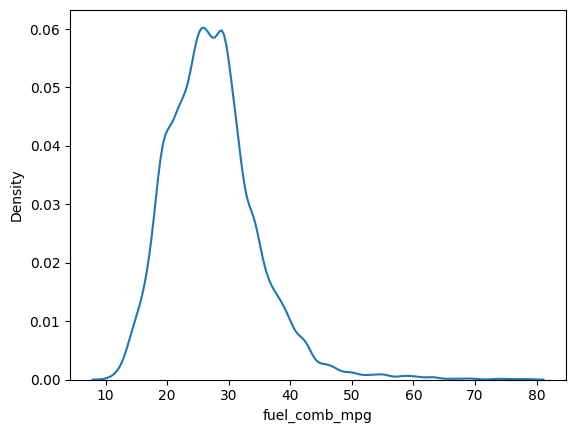

In [6]:
sns.kdeplot(train[target]);

In [7]:
features_num = list(train.columns[train.dtypes != "object"])
features_num

['year',
 'engine_size',
 'cylinders',
 'fuel_city_Lkm',
 'fuel_hwy_Lkm',
 'fuel_comb_Lkm',
 'fuel_comb_mpg',
 'co2']

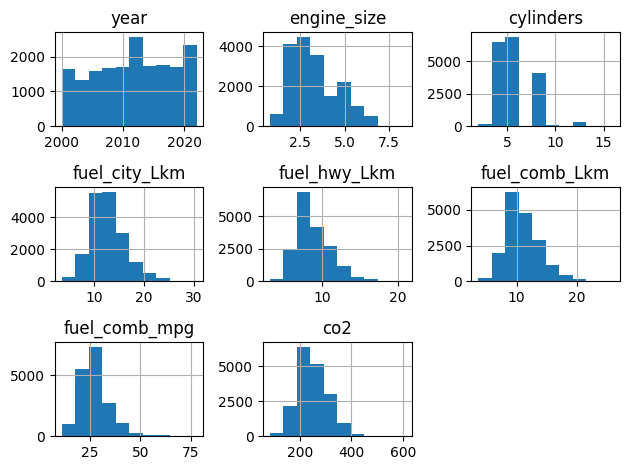

In [8]:
train[features_num].hist()
plt.tight_layout()

In [9]:
features_log = features_num.copy()
features_log.remove("year")
features_log.remove(target)
features_log.remove("cylinders")
features_log

['engine_size', 'fuel_city_Lkm', 'fuel_hwy_Lkm', 'fuel_comb_Lkm', 'co2']

In [10]:
train["cylinders"] = train["cylinders"].astype("object")

In [11]:
# Selección categoricas 
categorical_cols = list(train.select_dtypes(include = ['object']).columns)
print(categorical_cols)

['brand', 'model', 'vehicle_class', 'cylinders', 'transmission', 'fuel_type']


In [12]:
# #Hay valores repetidos pero escritos diferente.Normalizamos:

# train[categorical_cols] = train[categorical_cols].apply(lambda x: x.astype(str).str.lower())

In [41]:
# Limpieza de strings (en vez de la celda anterior)
def clean_categoricals(df):
    return df.apply(lambda col: col.astype(str).str.lower())

cleaner = FunctionTransformer(clean_categoricals)


# Pipeline categoricas
cat_pipeline = Pipeline([
    ("cleaner", cleaner),
    ("impute_mode", SimpleImputer(strategy = "most_frequent")),  # metemos la moda 
    ("ohencoder", OneHotEncoder(handle_unknown = "ignore"))      
])

# -------------------------------------------------------------------------------------------------------

# Transformación logarítmica
# log_transformer = FunctionTransformer(lambda x: np.log1p(x))

# Pipeline para transformación logarítmica y escalado de las numericas
num_pipeline = Pipeline([
    #("log", log_transformer),
    ("scaler", MinMaxScaler()) 
])

# --------------------------------------------------------------------------------------------------------

preprocessing = ColumnTransformer([
        ("cat", cat_pipeline, categorical_cols),
        ("log_and_scaler", num_pipeline, features_log), 
        ("scaler_only", MinMaxScaler(), ["year"]),
        ("exclude", "drop", target)
]) 

# X_train = preprocessing.fit_transform(train)
# print(X_train.shape)

In [42]:
# Pipeline para Linear Regression
lr_pipeline = Pipeline([
    ('Premodelado', preprocessing),   
    ('ModeloRegressor', LinearRegression())
])

# Pipeline para Random Forest
rf_pipeline = Pipeline([
    ('Premodelado', preprocessing),
    ('ModeloRegressor', RandomForestRegressor(random_state=42))
])

# Pipeline para XGBoost
xgb_pipeline = Pipeline([
    ('Premodelado', preprocessing),
    ('ModeloRegressor', xgb.XGBRegressor(random_state=42))
])

In [15]:
y_train = np.log1p(train[target]).to_numpy()

In [16]:
y_train.shape

(18044,)

In [18]:
cv = 5

#se aplica la validacion cruzada a cada modelo 
#scoring utilizo la raiz del error cuadratico medio
for name, pipe in zip(["lr_pipeline", "rf_pipeline", "xgb_pipeline"], [lr_pipeline, rf_pipeline, xgb_pipeline]):
    resultado = cross_val_score(pipe, train, y_train, cv = cv, scoring = "neg_root_mean_squared_error")
    print(f"{name}: {-np.mean(resultado):.5f}")
    #print(-resultado)

lr_pipeline: 0.01179
rf_pipeline: 0.00071
xgb_pipeline: 0.00095


In [43]:
# Linear Regression
lr_params = {
    'ModeloRegressor__fit_intercept': [True, False], # si tiene o no intercept
}

lr_grid = GridSearchCV(
    lr_pipeline, 
    lr_params, 
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# Random Forest GridSearchCV
rf_params = {
    'ModeloRegressor__n_estimators': [100, 200],
    'ModeloRegressor__max_depth': [None, 10, 50],
    'ModeloRegressor__min_samples_split': [2, 5],
    # 'ModeloRegressor__bootstrap': [True, False] #`bootstrap`: Puede ser interesante probar tanto True como False  
}

rf_grid = GridSearchCV(
    rf_pipeline, 
    rf_params, 
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

# XGBoost GridSearchCV
xgb_params = {
    'ModeloRegressor__n_estimators': [50, 200],
    # 'ModeloRegressor__learning_rate': [0.05, 0.1],
    # 'ModeloRegressor__max_depth': [3, 10],
    # 'ModeloRegressor__subsample': [0.8, 1.0]
}

xgb_grid = GridSearchCV(
    xgb_pipeline, 
    xgb_params, 
    cv=cv, 
    scoring='neg_root_mean_squared_error',
    verbose=1,
    n_jobs=-1
)

pipe_grids = {"gs_lr": lr_grid,
         "gs_rand_forest": rf_grid,
         "gs_xgb": xgb_grid}

In [ ]:
for nombre, grid_search in pipe_grids.items():
    grid_search.fit(train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits


In [31]:
best_grids = [(i, j.best_score_) for i, j in pipe_grids.items()]

best_grids = pd.DataFrame(best_grids, columns=["Grid", "Best score"]).sort_values(by="Best score", ascending=False)
best_grids

,Grid,Best score
1,gs_rand_forest,-0.000700
2,gs_xgb,-0.000839
0,gs_lr,-0.011791


In [32]:
best_model = pipe_grids[best_grids.iloc[0,0]]

In [39]:
best_model

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('Premodelado',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cleaner',
                                                                                          FunctionTransformer(func=<function clean_categoricals at 0x000001EFF98991C0>)),
                                                                                         ('impute_mode',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         ['brand',
                                                                          'model',
                                                                          'vehicle_class',
                                                                          'cyli...
                                                                          'co2']),
                                                                        ('scaler_only',
                                                                         MinMaxScaler(),
                                                                         ['year']),
                                                                        ('exclude',
                                                                         'drop',
                                                                         'fuel_comb_mpg')])),
                                       ('ModeloRegressor',
                                        RandomForestRegressor(random_state=42))]),
             n_jobs=-1,
             param_grid={'ModeloRegressor__max_depth': [None, 10, 20, 50],
                         'ModeloRegressor__min_samples_split': [2, 5],
                         'ModeloRegressor__n_estimators': [50, 100, 200]},
             scoring='neg_root_mean_squared_error', verbose=1)

In [33]:
rf_grid.best_params_

{'ModeloRegressor__max_depth': 10,
 'ModeloRegressor__min_samples_split': 2,
 'ModeloRegressor__n_estimators': 200}

In [38]:
# # Usando pickle:
# with open('modelo_pipeline.pkl', 'wb') as archivo:
#     pickle.dump(best_model, archivo)

# Usando joblib:
joblib.dump(best_model, 'modelo_pipeline.joblib')

PicklingError: Can't pickle <function <lambda> at 0x000001EFF98998A0>: it's not found as __main__.<lambda>